<center><img src="http://mdst.eecs.umich.edu/images/mdst-logo-circle.png" width=350></center>

Let's get the data loaded right away so that we don't have to think about it.

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

train_df = pd.read_csv('./data/flint_train.csv')
test_df = pd.read_csv('./data/flint_test.csv')

dummy_columns = ['Owner_Type', 'Residential_Building_Style', 'USPS_Vacancy', 
                 'Building_Storeys', 'Rental', 'Use_Type', 'Prop_Class', 'Zoning', 'Future_Landuse', 'DRAFT_Zone',
                 'Housing_Condition_2012', 'Housing_Condition_2014','Hydrant_Type', 'Ward', 'PRECINCT', 'CENTRACT', 
                 'Commercial_Condition_2013','CENBLOCK', 'SL_Type', 'SL_Type2', 'SL_Lead', 'Homestead']

drop_columns = ['sample_id', 'google_add', 'parcel_id', 'Date_Submitted']

combined_df = train_df.append(test_df)

combined_df = combined_df.drop(drop_columns, axis=1)
combined_df = pd.get_dummies(combined_df, columns = dummy_columns)

train_df = combined_df[:len(train_df)]
test_df = combined_df[len(train_df):]

# The combining of the dataframes created an empty column for lead in test_df.  We drop it here.
test_df = test_df.drop('Lead_(ppb)', axis=1)

In [2]:
from sklearn.cross_validation import train_test_split

Ydata_r = train_df['Lead_(ppb)']
Ydata_c = train_df['Lead_(ppb)'] > 15
Xdata = train_df.drop('Lead_(ppb)', axis=1)

# We'll be starting with a regression problem, so split on Ydata_r

Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xdata, Ydata_c)

# Hyperparameter Tuning

In this tutorial we will discuss "tuning" a model from scikit-learn.  So far we have created several models to predict which homes in Flint have dangerous water in their pipes.  However, for the most part these models have been "vanilla."  In other words, we have been using them with only default parameter values.  For example

In [3]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

rf.fit(Xtrain, Ytrain)
yhat1 = rf.predict_proba(Xtest)

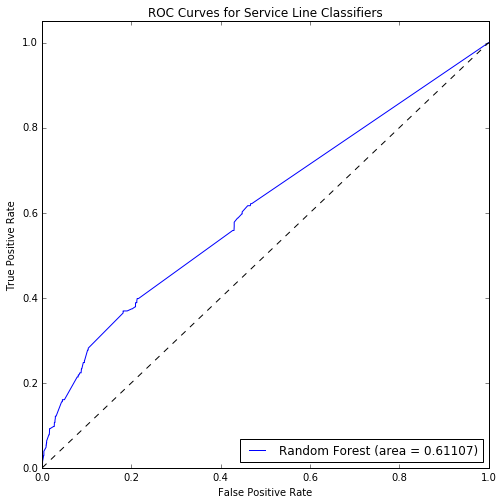

In [4]:
from sklearn.metrics import roc_auc_score as roc
from sklearn.metrics import roc_curve

fig = plt.figure()
fig.set_size_inches(8,8)

fpr, tpr, _ = roc_curve(Ytest, yhat1[:,1])
plt.plot(fpr, tpr, label= 'Random Forest (area = %0.5f)' % roc(Ytest, yhat1[:,1]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Service Line Classifiers')
plt.legend(loc="lower right")

plt.show()

This is a decent classifier.  However, if you remember last time we changed one of the parameters when we created the random forest object - the number of trees in the forest.  This was done as follows:

In [5]:
rf = RandomForestClassifier(n_estimators=1024, n_jobs=-1)
rf.fit(Xtrain, Ytrain)
yhat2 = rf.predict_proba(Xtest)

rf = RandomForestClassifier(n_estimators=1)
rf.fit(Xtrain, Ytrain)
yhat3 = rf.predict_proba(Xtest)

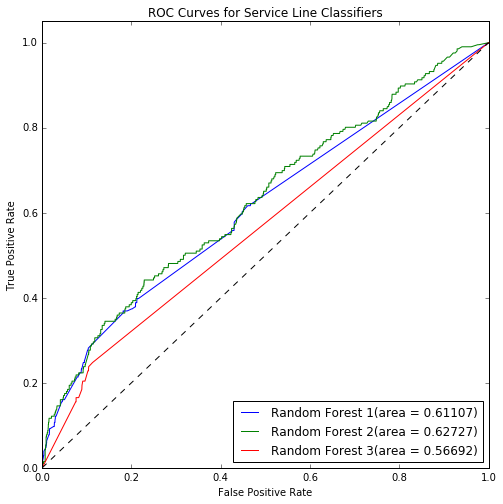

In [6]:
fig = plt.figure()
fig.set_size_inches(8,8)

fpr, tpr, _ = roc_curve(Ytest, yhat1[:,1])
plt.plot(fpr, tpr, label= 'Random Forest 1(area = %0.5f)' % roc(Ytest, yhat1[:,1]))

fpr, tpr, _ = roc_curve(Ytest, yhat2[:,1])
plt.plot(fpr, tpr, label= 'Random Forest 2(area = %0.5f)' % roc(Ytest, yhat2[:,1]))

fpr, tpr, _ = roc_curve(Ytest, yhat3[:,1])
plt.plot(fpr, tpr, label= 'Random Forest 3(area = %0.5f)' % roc(Ytest, yhat3[:,1]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Service Line Classifiers')
plt.legend(loc="lower right")

plt.show()

Changing this one parameter can changed the score for our classifier.  One choice decreased the score, and another increased it.  What other parameters does a random forest have?

In [7]:
rf = RandomForestClassifier(n_estimators=10, 
                            criterion='gini', 
                            max_depth=None, 
                            min_samples_split=2, 
                            min_samples_leaf=1, 
                            min_weight_fraction_leaf=0.0, 
                            max_features='auto', 
                            max_leaf_nodes=None, 
                            bootstrap=True, 
                            oob_score=False, 
                            n_jobs=1, 
                            random_state=None, 
                            verbose=0, 
                            warm_start=False, 
                            class_weight=None)

In [8]:
# Change some of the parameters of the random forest model above, and then run the code below.
# Experiment to see if you can improve the roc score.

rf.fit(Xtrain, Ytrain)
yhat = rf.predict_proba(Xtest)
print(roc(Ytest, yhat[:,1]))

0.619202844568


That's a lot.  What about a linear model?  Say, ridge regression?

In [9]:
from sklearn.linear_model import RidgeClassifier

ri = RidgeClassifier(alpha=1.0, 
                     fit_intercept=True, 
                     normalize=False,
                     copy_X=True, 
                     max_iter=None, 
                     tol=0.001, 
                     class_weight=None, 
                     solver='auto', 
                     random_state=None)

Not quite as many, but still a lot.  Normal human beings can't keep track of every parameter of every model.  Also, sotware evolves and can change.  There is no guarantee that if you learn all the parameters of all the models now that in a few years new parameters won't be introduced.  It is better to do what a typical mortal does - check the documentation.

<a href="http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html">Random forest documentation</a>

<a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html">Ridge regression documentation</a>

So now we know that these parameters exist.  We know how to change them.  The next question: How should we choose them?  One way is to do an exhaustive search.  Rather than code one up ourselves, sklearn saves the day again.

In [11]:
from sklearn.grid_search import GridSearchCV


#GridSearchCV(estimator,            A model like random forest, linear regression, etc.
#            param_grid,            A dictionary of parameters to try
#            n_jobs=1,              Parallelize?
#            cv=None,               How many cross validation folds?
#            verbose=0,             How much do you want the function to talk to you?
#            error_score='raise')   What should the function do if a model breaks?


In your own words, explain what cross validation is and why you would use it.

We illustrate an example of using a grid search below:

In [12]:
# First decide what kind of model you want to use.  We'll stick with a random forest.
# Create the object without changing any parameters.
rf = RandomForestClassifier()

# Now, create a dictionary of parameters to try.
param_dict={'n_estimators':[32, 64, 128, 256],
            'criterion':['gini', 'entropy'],
            'min_samples_split':[2,4,6]}

# Create the grid search classifier with your desired parameters.
grid_search_clf = GridSearchCV(rf, param_dict, n_jobs=-1, cv=3, verbose=3)

In [13]:
# Now we can fit and predict like any other model.
grid_search_clf.fit(Xtrain, Ytrain)

In [47]:
yhat_g = grid_search_clf.predict_proba(Xtest)

# Which parameters worked the best?
print(grid_search_clf.best_params_)

{'n_estimators': 256, 'criterion': 'gini', 'min_samples_split': 6}


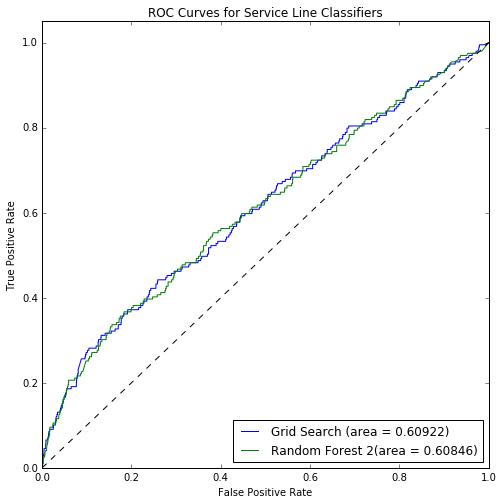

In [48]:
fig = plt.figure()
fig.set_size_inches(8,8)

fpr, tpr, _ = roc_curve(Ytest, yhat_g[:,1])
plt.plot(fpr, tpr, label= 'Grid Search (area = %0.5f)' % roc(Ytest, yhat_g[:,1]))

fpr, tpr, _ = roc_curve(Ytest, yhat2[:,1])
plt.plot(fpr, tpr, label= 'Random Forest 2(area = %0.5f)' % roc(Ytest, yhat2[:,1]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Service Line Classifiers')
plt.legend(loc="lower right")

plt.show()

What are some of the potential issues you could run into using GridSearchCV?

This is a straightforward way to explore the parameter space of our models.  However, it is not necessarily the most efficient.  For high dimensional parameter spaces, it has been observed that RANDOM sampling of the parameter space works better.  Fortunately sklearn has a function to do that as well:  RandomizedSearchCV.  It is a little trickier to use so I will omit it for now.  I highly recommend you look over the documentation <a href="http://scikit-learn.org/0.15/modules/generated/sklearn.grid_search.RandomizedSearchCV.html">here</a>